<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/edgar/Rakuten_py_NLP_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

Récuperer les données:

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))
 
df_X = pd.read_csv('/content/drive/My Drive/Rakuten/X_train_update.csv',index_col=0)
df_y = pd.read_csv('/content/drive/My Drive/Rakuten/Y_train_CVw08PX.csv',index_col=0)

In [82]:
lemmatizer = WordNetLemmatizer()

def lemma(sentence): #Lemmatizer
    doc = word_tokenize(sentence, language='french')
    return [lemmatizer.lemmatize(token) for token in doc]

def stop_words_filetring(mots) : 
    tokens = []
    for mot in mots:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

def clean_text(text):
    string = ''
    words = word_tokenize(text.lower(), language='french')
    for word in words:
        if word not in stop_words:
            if word.isascii() and word.isalpha():
              string += lemmatizer.lemmatize(word) + ' '
    return string

On netoye un peu le texte:

In [83]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [84]:
X = df_X.designation.astype(str) + ' ' + df_X.description.astype(str)
y = df_y.prdtypecode

X_clean = X.apply(lambda cell: clean_text(cell))
X_clean

0        olivia personalisiertes notizbuch seiten punkt...
1        journal art marche salon asiatique a paris jac...
2        grand stylet ergonomique bleu gamepad nintendo...
3        peluche donald europe disneyland marionnette d...
4        guerre tuques luc a id eacute grandeur veut or...
                               ...                        
84911                         the sims import anglais nan 
84912    kit piscine acier nevada pierre x b descriptio...
84913    journal officiel republique francaise changeme...
84914    table basse bois massif base blanche p cette t...
84915    gomme collection gommes pinguin glace vert ora...
Length: 84916, dtype: object

Combien de mots uniques?

In [85]:
lis = []
for element in X_clean.str.split():
    for word in element:
        lis.append(word)

len(list(set(lis)))

99865

Transformer les categories en numeros de 0 à 26:

In [86]:
categories = list(set(y.to_list()))
y_trans = y
i = 0
for category in categories:
    y_trans = y_trans.replace(category,i)
    i+=1

y_trans

0         4
1        25
2        20
3         0
4         6
         ..
84911    17
84912    10
84913    25
84914    11
84915    23
Name: prdtypecode, Length: 84916, dtype: int64

Separer en train et test

In [87]:
# Importer la classe train_test 
from sklearn.model_selection import train_test_split

# Séparer le jeu de données en données d'entraînement et données test 
X, X_valid, y, y_valid = train_test_split(X_clean, y_trans,train_size=0.05, test_size=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Validation size is',y_train.size ,'test size is', y_test.size, 'and validation size is', y_valid.size)

Validation size is 3396 test size is 849 and validation size is 850


Vectoriser avec TF-IDF

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(analyzer='word',
                  tokenizer=word_tokenize,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  )

X_train = tfid.fit_transform(X_train).todense()
X_test = tfid.transform(X_test).todense()
X_valid = tfid.transform(X_valid).todense()

Vectoriser avec CountVectoriser:

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser un objet vectorisateur
#vectorizer = CountVectorizer()

# Mettre à jour la valeur de X_train et X_test
#X_train = vectorizer.fit_transform(X_train).todense()
#X_test = vectorizer.transform(X_test).todense()

Utiliser modèle XGBoost:

In [89]:
import xgboost as xgb

train = xgb.DMatrix(X_train,y_train)
test = xgb.DMatrix(X_test,y_test)
valid = xgb.DMatrix(X_valid,y_valid)

In [90]:

from datetime import datetime

params = {'booster':'gbtree', 'learning_rate': 1,'objective':'multi:softmax','num_class':27}

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

xgb1 = xgb.train(params = params,
                 dtrain = train,
                 num_boost_round= 100,
                 early_stopping_rounds= 5,
                 evals= [(train, 'train'), (test, 'eval')])

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:56:59
[0]	train-merror:0.430801	eval-merror:0.486455
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 5 rounds.
[1]	train-merror:0.369847	eval-merror:0.487633
[2]	train-merror:0.301237	eval-merror:0.465253
[3]	train-merror:0.260012	eval-merror:0.434629
[4]	train-merror:0.226737	eval-merror:0.424028
[5]	train-merror:0.201708	eval-merror:0.40636
[6]	train-merror:0.178445	eval-merror:0.413428
[7]	train-merror:0.163722	eval-merror:0.409894
[8]	train-merror:0.150766	eval-merror:0.402827
[9]	train-merror:0.142226	eval-merror:0.401649
[10]	train-merror:0.130448	eval-merror:0.400471
[11]	train-merror:0.117491	eval-merror:0.400471
[12]	train-merror:0.111896	eval-merror:0.401649
[13]	train-merror:0.106007	eval-merror:0.404005
[14]	train-merror:0.099529	eval-merror:0.404005
[15]	train-merror:0.097762	eval-merror:0.396938
[16]	train-merror:0.095112	eval-merror:0.394582
[17]	train-merror:0.091578	

Un peu trop d'overfitting

Analyse predictions:

In [108]:
preds = pd.Series(xgb1.predict(valid).astype(int))
import numpy as np

y_valid.index = np.arange(0,len(y_valid))
y_valid

pd.crosstab(preds,y_valid)

prdtypecode,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19,3,1,1,0,1,0,5,0,0,0,2,2,2,0,0,0,2,1,0,0,0,0,4,0,0,1
1,2,7,0,0,1,0,0,0,0,0,0,1,3,0,1,0,0,1,1,0,0,0,0,0,0,0,0
2,0,0,22,0,0,2,0,1,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,0,1,0,34,5,0,3,2,0,0,0,0,0,1,0,2,1,2,0,0,1,0,0,1,6,2,3
4,1,0,0,2,12,1,3,0,0,0,2,0,0,1,1,1,0,0,2,1,1,0,0,1,3,9,1
5,1,1,3,0,1,30,1,1,0,5,2,5,1,2,0,0,0,0,3,1,1,0,0,0,0,1,0
6,0,0,0,0,2,1,12,0,1,1,0,0,1,0,0,2,0,1,0,0,0,0,0,0,1,0,0
7,11,0,0,0,0,0,0,31,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


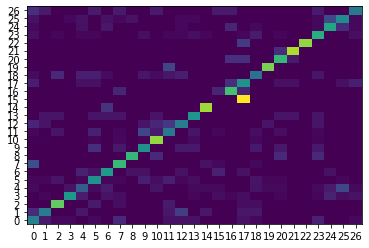

In [127]:
import matplotlib.pyplot as plt

df = pd.crosstab(preds,y_valid)
somme = df.apply(np.sum,axis=1)

#ponderation par ligne
df = df.apply(lambda cell: cell/somme[cell.index])

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

On observe que la classe 14 n'a pas été très bien classifié

In [ ]:
from sklearn.model_selection import GridSearchCV

params = 
gridCV = GridSearchCV(xgb1,params,scoring='accuracy',cv=3)

